In [1]:
import os
import calendar
import pandas as pd
import numpy as np

In [2]:
raw_df=pd.read_csv(r'C:\Users\bhava\OneDrive\Documents\AMPBA\Capstone\Reviews\Raw Files\combinedReviews.csv')

In [3]:
df=raw_df.copy()

In [4]:
df=df[df['cons'].notna() & df['pros'].notna()]

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhava\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [7]:
df.cons.isna().sum()

0

In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.pros.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['only', 'my', 'collegues', 'and', 'work', 'culture', 'there', 'is', 'no', 'option', 'to', 'rate', 'below', 'for', 'compensation', 'benefits', 'and', 'job', 'oppotunities', 'otherwise', 'could', 'have', 'given', 'the', 'same', 'salary', 'differes', 'from', 'location', 'wise', 'even', 'if', 'you', 'are', 'doing', 'same', 'job', 'what', 'other', 'are', 'doing', 'just', 'because', 'of', 'different', 'location']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())
#> [(0,
#>   '0.017*"write" + 0.015*"people" + 0.014*"organization" + 0.014*"article" + '
#>   '0.013*"time" + 0.008*"give" + 0.008*"first" + 0.007*"tell" + 0.007*"new" + '
#>   '0.007*"question"'),
#>  (1,
#>   '0.008*"christian" + 0.008*"believe" + 0.007*"god" + 0.007*"law" + '
#>   '0.006*"state" + 0.006*"israel" + 0.006*"israeli" + 0.005*"exist" + '
#>   '0.005*"way" + 0.004*"bible"'),
#>  (2,
#>   '0.024*"armenian" + 0.012*"bike" + 0.006*"kill" + 0.006*"work" + '
#>   '0.005*"well" + 0.005*"year" + 0.005*"sumgait" + 0.005*"soldier" + '
#>   '0.004*"way" + 0.004*"ride"'),
#>  (3,
#>   '0.019*"team" + 0.019*"game" + 0.013*"hockey" + 0.010*"player" + '
#>   '0.009*"play" + 0.009*"win" + 0.009*"nhl" + 0.009*"year" + 0.009*"hawk" + '
#>   '0.009*"season"')]

[(0,
  '0.089*"company" + 0.038*"learn" + 0.033*"wipro" + 0.031*"employee" + '
  '0.029*"opportunity" + 0.029*"project" + 0.026*"salary" + 0.026*"growth" + '
  '0.024*"experience" + 0.023*"skill"'),
 (1,
  '0.074*"work" + 0.049*"wipro" + 0.047*"management" + 0.037*"great" + '
  '0.027*"team" + 0.021*"manager" + 0.019*"place" + 0.017*"thing" + '
  '0.017*"technology" + 0.015*"support"'),
 (2,
  '0.212*"work" + 0.122*"culture" + 0.118*"job" + 0.109*"security" + '
  '0.064*"environment" + 0.053*"life" + 0.045*"balance" + 0.037*"policy" + '
  '0.025*"supportive" + 0.019*"teammate"')]


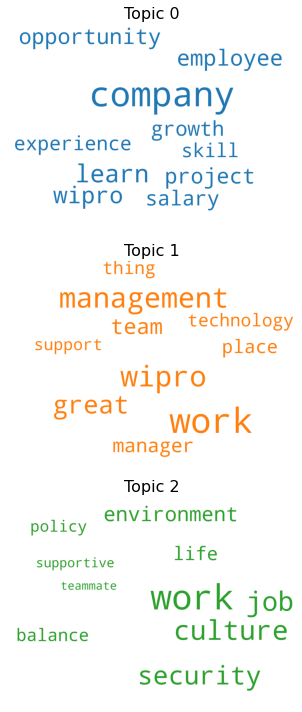

In [11]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [12]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-12-eb06ae184486>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
<ipython-input-12-eb06ae184486>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.608,"company, learn, wipro, employee, opportunity, ...","[collegue, work, culture, option, rate, compen..."
1,1,0,0.426,"company, learn, wipro, employee, opportunity, ...","[overall, experience, much, secure, term, job,..."
2,2,1,0.598,"work, wipro, management, great, team, manager,...","[job, security, client, customer, centric, com..."
3,3,1,0.501,"work, wipro, management, great, team, manager,...","[grow, organization, multiple, mechanical, eng..."
4,4,0,0.636,"company, learn, wipro, employee, opportunity, ...","[hcl, avery, organization, middle, management,..."
5,5,0,0.376,"company, learn, wipro, employee, opportunity, ...","[job, security, join, hcl, age, career, growth..."
6,6,1,0.585,"work, wipro, management, great, team, manager,...","[thing, salary, time, end, month, sometimes, f..."
7,7,0,0.487,"company, learn, wipro, employee, opportunity, ...","[incredibly, talented, mid, management, lucky,..."
8,8,0,0.333,"company, learn, wipro, employee, opportunity, ...",[]
9,9,0,0.646,"company, learn, wipro, employee, opportunity, ...","[thing, work, ther, benefit, provide, employee..."


In [13]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.963,"company, learn, wipro, employee, opportunity, project, salary, growth, experience, skill","[tcs, give, opportunity, employee, learn, tcs, employee, access, various, learning, platform, li..."
1,1,0.972,"work, wipro, management, great, team, manager, place, thing, technology, support","[team, leader, guide, small, thing, refund, amount, spend, internet, infosy, time, work, day, mi..."
2,2,0.945,"work, culture, job, security, environment, life, balance, policy, supportive, teammate","[work, environment, culter, teammate, supportive, management, transparent, hug, indan, job, garm..."


In [14]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

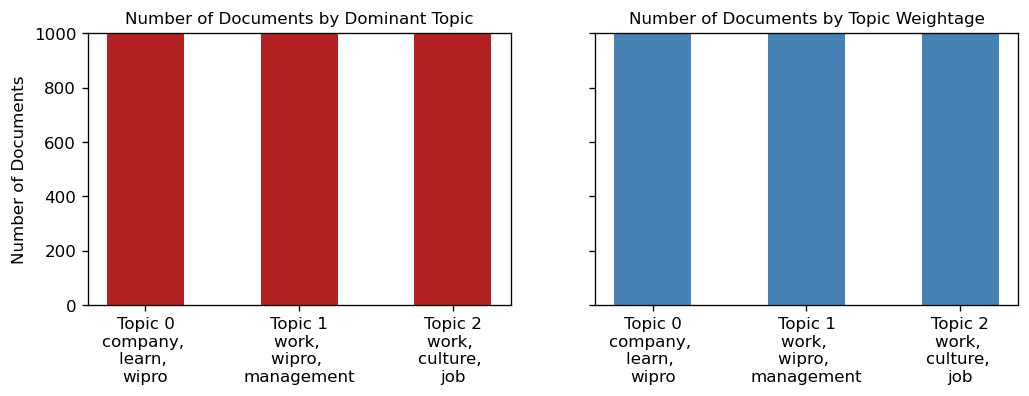

In [15]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [16]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 78165 samples in 0.080s...
[t-SNE] Computed neighbors for 78165 samples in 1.504s...
[t-SNE] Computed conditional probabilities for sample 1000 / 78165
[t-SNE] Computed conditional probabilities for sample 2000 / 78165
[t-SNE] Computed conditional probabilities for sample 3000 / 78165
[t-SNE] Computed conditional probabilities for sample 4000 / 78165
[t-SNE] Computed conditional probabilities for sample 5000 / 78165
[t-SNE] Computed conditional probabilities for sample 6000 / 78165
[t-SNE] Computed conditional probabilities for sample 7000 / 78165
[t-SNE] Computed conditional probabilities for sample 8000 / 78165
[t-SNE] Computed conditional probabilities for sample 9000 / 78165
[t-SNE] Computed conditional probabilities for sample 10000 / 78165
[t-SNE] Computed conditional probabilities for sample 11000 / 78165
[t-SNE] Computed conditional probabilities for sample 12000 / 78165
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [17]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

c:\Users\bhava\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.363262 -0.073023       1        1  36.720167
2      0.257827 -0.224588       2        1  31.702454
1      0.105435  0.297611       3        1  31.577379, topic_info=            Term          Freq         Total Category  logprob  loglift
15          work  39294.000000  39294.000000  Default  30.0000  30.0000
3        culture  16759.000000  16759.000000  Default  29.0000  29.0000
7            job  16228.000000  16228.000000  Default  28.0000  28.0000
60      security  15003.000000  15003.000000  Default  27.0000  27.0000
74       company  14242.000000  14242.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
146        offer    541.780077    542.345615   Topic3  -5.5329   1.1517
86    management   6443.442625   8330.434449   Topic3  -3.0569   0.8959
3148       wipro   6663.499190  11990.196764   Topic3  -3.0234   0.5653
15          work  10074.982014  39294.893809   Topic3  -2.6099  -0.2083
269   supportive   1006.440489   4428.902803   Topic3  -4.9136  -0.3290

[138 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
71        3  0.999792     always
72        1  0.999399  appraisal
777       2  0.999551    awesome
281       3  0.999315        bad
19        2  0.999941    balance
...     ...       ...        ...
15        2  0.743608       work
15        3  0.256395       work
292       2  0.443299    working
292       3  0.555563    working
178       1  0.999954       year

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])